In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1F1F1F'
plt.rcParams['axes.facecolor'] = '#1F1F1F'
plt.rcParams['savefig.facecolor'] = '#1F1F1F'

import os
import subprocess
def check_mig_with_smi():
    try:
        output = subprocess.check_output(["nvidia-smi", "-L"], text=True)
        return "MIG" in output
    except (subprocess.CalledProcessError, FileNotFoundError):
        return False

if check_mig_with_smi():
    print("Running on a GPU MIG instance")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    print("Not running on a GPU MIG instance")


Running on a GPU MIG instance


In [3]:
import math
from functools import partial

import torch
from einops import rearrange
from einops.layers.torch import Rearrange
from torch import einsum, nn


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, dim_out, 3, padding=1),
    )


def Downsample(dim, dim_out):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, dim_out, 1),
    )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim, groups=8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2),
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        time_emb = self.mlp(time_emb)
        time_emb = rearrange(time_emb, "b c -> b c 1 1")
        scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = dim
        self.init_conv = nn.Conv2d(
            input_channels, init_dim, 1, padding=0
        )  # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        (
                            Downsample(dim_in, dim_out)
                            if not is_last
                            else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                        ),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        (
                            Upsample(dim_out, dim_in)
                            if not is_last
                            else nn.Conv2d(dim_out, dim_in, 3, padding=1)
                        ),
                    ]
                )
            )

        self.out_dim = channels

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

Epoch 1, Loss: 0.4421164957699237
Epoch 2, Loss: 0.3181201551895914
Epoch 3, Loss: 0.30314547563793814
Epoch 4, Loss: 0.2967175919173369
Epoch 5, Loss: 0.2933774476430055
Epoch 6, Loss: 0.2902867170348605
Epoch 7, Loss: 0.2870224686001918
Epoch 8, Loss: 0.28519816096149275
Epoch 9, Loss: 0.284771832067575
Epoch 10, Loss: 0.28482946194311193
Epoch 11, Loss: 0.2802467382093991
Epoch 12, Loss: 0.2812600677519211
Epoch 13, Loss: 0.27831093782682154
Epoch 14, Loss: 0.2793014007908449
Epoch 15, Loss: 0.2777850949433821
Epoch 16, Loss: 0.2764969568516908
Epoch 17, Loss: 0.2781070800923081
Epoch 18, Loss: 0.2742491806112627
Epoch 19, Loss: 0.2757448955639593
Epoch 20, Loss: 0.2743345424374029


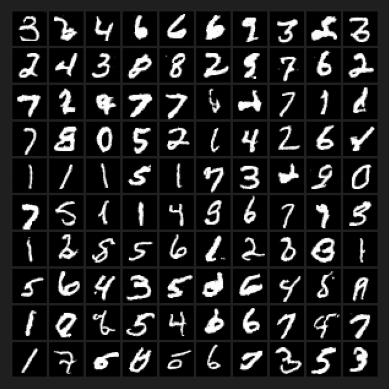

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
from scipy import integrate
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


batch_size = 128
learning_rate = 0.001
num_epochs = 20
eps = 0.001


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet(
    dim=32,
    channels=1,
    dim_mults=(1, 2, 4),
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def euler_sampler(model, shape, sample_N):
    model.eval()
    with torch.no_grad():
        z0 = torch.randn(shape, device=device)
        x = z0.detach().clone()

        dt = 1.0 / sample_N
        for i in range(sample_N):
            num_t = i / sample_N * (1 - eps) + eps
            t = torch.ones(shape[0], device=device) * num_t
            pred = model(x, t * 999)

            x = x.detach().clone() + pred * dt

        nfe = sample_N
        return x.cpu(), nfe


def to_flattened_numpy(x):
    return x.detach().cpu().numpy().reshape((-1,))


def from_flattened_numpy(x, shape):
    return torch.from_numpy(x.reshape(shape))


def rk45_sampler(model, shape):

    rtol = atol = 1e-05
    model.eval()
    with torch.no_grad():
        z0 = torch.randn(shape, device=device)
        x = z0.detach().clone()

        def ode_func(t, x):
            x = from_flattened_numpy(x, shape).to(device).type(torch.float32)
            vec_t = torch.ones(shape[0], device=x.device) * t
            drift = model(x, vec_t * 999)

            return to_flattened_numpy(drift)

        solution = integrate.solve_ivp(
            ode_func,
            (eps, 1),
            to_flattened_numpy(x),
            rtol=rtol,
            atol=atol,
            method="RK45",
        )
        nfe = solution.nfev
        x = torch.tensor(solution.y[:, -1]).reshape(shape).type(torch.float32)

        return x, nfe


def imshow(img, filename):
    img = img * 0.3081 + 0.1307
    img = np.clip(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap="gray")
    plt.axis("off")
    plt.savefig(filename, bbox_inches="tight", pad_inches=0)


def save_img_grid(img, filename):
    img_grid = torchvision.utils.make_grid(img, nrow=10)
    imshow(img_grid, filename)


for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch, _ in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()

        z0 = torch.randn_like(batch)
        t = torch.rand(batch.shape[0], device=device) * (1 - eps) + eps

        t_expand = t.view(-1, 1, 1, 1).repeat(
            1, batch.shape[1], batch.shape[2], batch.shape[3]
        )
        #print(t_expand.shape)
        perturbed_data = t_expand * batch + (1 - t_expand) * z0
        target = batch - z0

        score = model(perturbed_data, t * 999)

        losses = torch.square(score - target)
        losses = torch.mean(losses.reshape(losses.shape[0], -1), dim=-1)

        loss = torch.mean(losses)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

    images, nfe = euler_sampler(model, shape=(100, 1, 28, 28), sample_N=1)
    save_img_grid(images, f"data/euler_epoch_{epoch + 1}_nfe_{nfe}.png")

    images, nfe = euler_sampler(model, shape=(100, 1, 28, 28), sample_N=2)
    save_img_grid(images, f"data/euler_epoch_{epoch + 1}_nfe_{nfe}.png")

    images, nfe = euler_sampler(model, shape=(100, 1, 28, 28), sample_N=10)
    save_img_grid(images, f"data/euler_epoch_{epoch + 1}_nfe_{nfe}.png")

    images, nfe = rk45_sampler(model, shape=(100, 1, 28, 28))
    save_img_grid(images, f"data/rk45_epoch_{epoch + 1}_nfe_{nfe}.png")